Author: Simon Fei - Triton NeuroTech at UCSD
<br>
Acknowledgement: Wearable Sensing, Brainda Project

## Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'axes.facecolor':'black'})
import pandas as pd
import mne
from sklearn.metrics import confusion_matrix, accuracy_score
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)
from collections import OrderedDict
from sklearn.pipeline import clone
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import sys
from matplotlib.colors import LogNorm

## Experimental constants

In [8]:
sub_dirs = ['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/']  # each folder is a single independent run
duration = 1.5  # duration of a trial in seconds
n_classes = 32  # number of classes, 8 freq, 4 phase, total of 8 * 4 = 32 targets
n_channels = 19  # number of recording channels
onset_delay = 42 # number of samples to discard to account for visual delay
srate = 300 # sampling rate of the headset (DSI-24)

## Data wrangling

In [9]:
def load_egg(eeg, meta, classes, stim_duration=5, sfreq=300, filter=True, drop_chan=['time',' TRG',' X1',' X2',' X3',' A2']):
    trials = meta[1:,:2]
    times = []
    duration_samples = int(stim_duration*sfreq)
    for index, row in eeg.loc[eeg[' TRG']==16.0].iterrows():
        if index > 0 and eeg.iloc[index-1][' TRG'] == 0 and (not eeg.iloc[index:index+duration_samples][' TRG'].isin([18.0]).any()):
            times.append(row['time'])
    times = np.array(times)
    
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

def load_dataset(path="../data/",
                sub_dirs=['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/','run10/'],
                drop_chan=['time',' TRG',' X1',' X2',' X3',' A2'],
                duration=1.5,
                n_trials=2,
                n_classes=32,
                sfreq=300):
    n_channels = 25 - len(drop_chan)
    # load experimental dataset
    eeg_whole = np.zeros((n_trials*len(sub_dirs),n_classes,n_channels,int(duration*sfreq)))
    target_tab = {}
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
        meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
        trials = meta[1:,:2]
        classes = np.unique(trials, axis=0)
        more_targets = {tuple(target):index for index,target in enumerate(classes)}
        target_tab.update(more_targets)
        eeg = load_egg(eeg, meta, classes, stim_duration=duration,filter=False,drop_chan=drop_chan)
        eeg_whole[i_dir*n_trials:(i_dir+1)*n_trials,:,:,:] = eeg
    eeg = eeg_whole
    target_by_trial = [list(target_tab.keys())] * n_trials*len(sub_dirs)
    print('\r', end='')
    print(eeg.shape, np.array(target_by_trial).shape)
    return eeg, target_by_trial, target_tab

In [10]:
eeg, target_by_trial, target_tab = load_dataset()

(20, 32, 19, 450) (20, 32, 2)                                   


## Apply Modeling Algorithm

In [14]:
def run_fbtrca(eeg, target_by_trial, target_tab, duration=1.0, onset_delay=42,srate=300):
    eeg = np.copy(eeg)
    np.random.seed(64)
    np.random.shuffle(eeg)
    n_trials = eeg.shape[0]
    classes = range(32)
    n_classes = len(classes)
    prob_matrix=np.zeros((n_classes,n_classes))
    y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
    eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
    X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

    n_bands = 3
    wp = [[8*i, 90] for i in range(1, n_bands+1)]
    ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
    filterbank = generate_filterbank(
        wp, ws, srate, order=4, rp=1)
    filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
    set_random_seeds(64)
    l = 5
    models = OrderedDict([
        ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ])
    events = []
    for j_class in classes:
        events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
    events = np.array(events)
    subjects = ['1'] * (n_classes*n_trials)
    meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
    set_random_seeds(42)
    loo_indices = generate_loo_indices(meta)

    for model_name in models:
        if model_name == 'fbtdca':
            filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
        else:
            filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
        
        filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

        n_loo = len(loo_indices['1'][events[0]])
        loo_accs = []
        testYs = []
        pred_labelss = []
        for k in range(n_loo):
            train_ind, validate_ind, test_ind = match_loo_indices(
                k, meta, loo_indices)
            train_ind = np.concatenate([train_ind, validate_ind])

            trainX, trainY = filterX[train_ind], filterY[train_ind]
            testX, testY = filterX[test_ind], filterY[test_ind]

            model = clone(models[model_name]).fit(
                trainX, trainY
            )
            pred_labels = model.predict(testX)
            loo_accs.append(
                balanced_accuracy_score(testY, pred_labels))
            pred_labelss.extend(pred_labels)
            testYs.extend(testY)
        print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))
    return confusion_matrix(testYs, pred_labelss, normalize='true'), accuracy_score(testYs, pred_labelss), model

def cm_graph(cm, acc):
    plt.figure(figsize=(7, 6))
    # ax = sns.heatmap(confusion_matrix(testYs, pred_Ys, normalize='true'), cmap='Blues_r', norm=LogNorm())
    ax = sns.heatmap(cm, cmap='Blues_r', norm=LogNorm())
    # ax.set_title('val acc: '+str(accuracy_score(testYs, pred_Ys)));
    ax.set_title('loo acc: '+str(acc));
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.xaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = -90);
    ax.yaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = 0);
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())
    plt.show()

In [12]:
confusion_matrix, mean_loo_accuracy, last_model = run_fbtrca(eeg, target_by_trial, target_tab, duration=duration, onset_delay=onset_delay)

Model:fbtrca LOO Acc:0.90


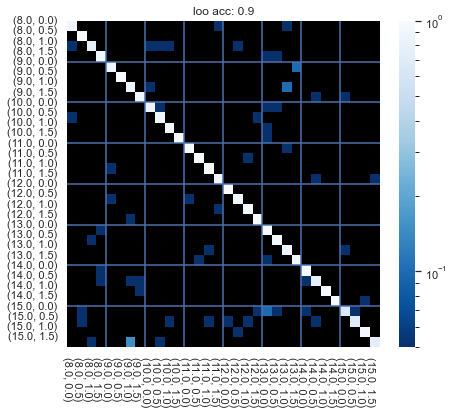

In [15]:
cm_graph(confusion_matrix, mean_loo_accuracy)

## Visualize Model Features

(32, 19, 408)


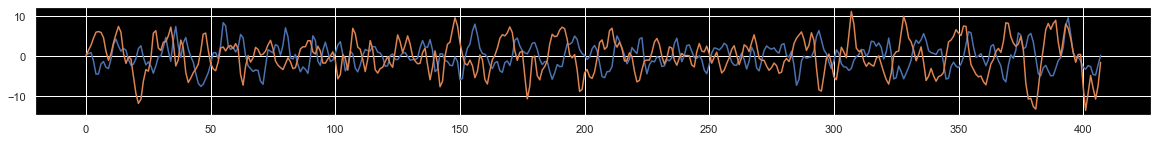

In [21]:
# the templates are trial average of the time series
templates = np.copy(last_model.estimators_[0].templates_)
print(templates.shape)
plt.figure(figsize=(20,2))
plt.plot(templates[28,14]);
plt.plot(templates[30,14]);

(32, 19, 408)


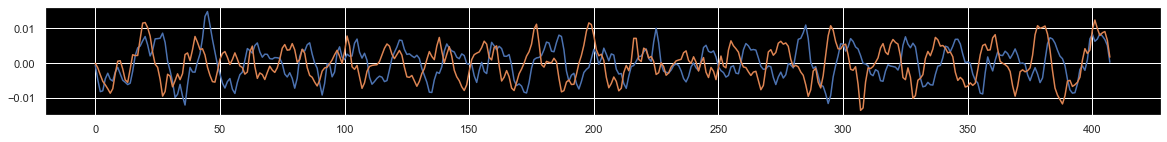

In [26]:
# Non-ensamble filtering of the templates
templates = np.copy(last_model.estimators_[0].templates_)
n_comp = last_model.estimators_[0].n_components

# This is the non-ensable way of applying the learned spatial filter to the templates
Us = last_model.estimators_[0].Us_ # copy over the filter
for i_template, template in enumerate(templates):
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)

print(templates.shape)
plt.figure(figsize=(20,2))
plt.plot(templates[28,14]);
plt.plot(templates[30,14]);

(32, 13056)


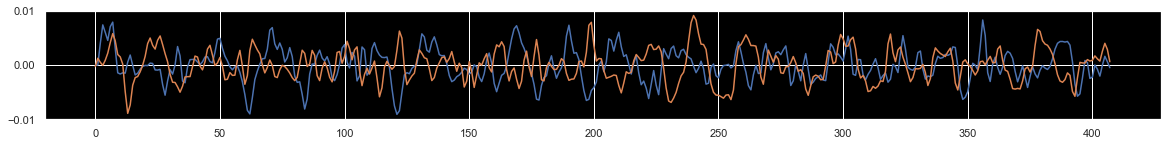

In [28]:
# Ensamble filtering of the templates
templates = np.copy(last_model.estimators_[0].templates_) # copy over the templates
U = np.copy(last_model.estimators_[0].Us_)[:, :, :last_model.n_components] # copy over the filter
U = np.concatenate(U, axis=-1)
filtered_templates=np.zeros((templates.shape[0],templates.shape[0]*templates.shape[2]))
for i_template, template in enumerate(templates):
    filtered_templates[i_template] = np.reshape((U.T@template),(-1))
    
print(filtered_templates.shape)
plt.figure(figsize=(20,2))
t_length=int(filtered_templates.shape[1]/filtered_templates.shape[0])
plt.plot(filtered_templates[28,:t_length]);
plt.plot(filtered_templates[30,:t_length]);